In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)

from csr2d.beam_conversion import particle_group_to_bmad, bmad_to_particle_group
from pmd_beamphysics.plot import marginal_plot, density_plot
from csr2d.simple_track import track_a_bend, track_a_drift, track_a_bend_parallel, track_a_drift_parallel


from csr2d.kick2 import csr2d_kick_calc, csr1d_steady_state_kick_calc

import time

from pmd_beamphysics.interfaces.elegant import elegant_to_data
from pmd_beamphysics import ParticleGroup

import concurrent.futures as cf

import warnings
warnings.filterwarnings("ignore")

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

### Glen's beam from Yunhai's 3D paper

In [2]:
# Glen's beam, which comes from Yunhai's 3D CSR paper!

gamma = 9804
# gamma = 9.784756043574142e+03  # Glen

rho = 10.34 # Bend radius in m
LB = 0.5     # Bend length in m

# Desired beam optics at the END of the bend ( see Yunhai's 3D CSR paper )
beta_xf  = 5.19   # in m
alpha_xf = 0
eta_xf   = 0      # in m
etap_xf  = 0

beta_yf  = 12.28   # in m
alpha_yf = 0
eta_yf   = 0      # in m
etap_yf  = 0

# With the parameters above we can calculate (using Bmad)
# the required INITIAL beam optics at the BEGINNING of the bend
beta_x  = 5.22600574   # in m
alpha_x = 0.07195534
eta_x   = 0.01208662     # in m
etap_x  = -0.04833706

beta_y = 12.30035831    # in m
alpha_y = 0.04071661
eta_y   = 0             # in m
etap_y  = 0

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m
norm_emit_y = 1e-6           # in m
emit_y = norm_emit_y / gamma # in m

# Bunch length and energy spread
sigma_z  = 2e-5
sigma_delta = 5e-5   # a small value picked by Glen


# Total charge
Nb = 6.25e9
Q = e_charge * Nb


## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * 510998.950 *(sigma_z/rho)**(2/3) / sigma_z**2



# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  


# Define an uncorrelated beam first
sigma_x = np.sqrt(emit_x * beta_x)
sigma_xp = np.sqrt(emit_x / beta_x)
sigma_y = np.sqrt(emit_y * beta_y)
sigma_yp = np.sqrt(emit_y / beta_y)

beam = np.zeros((6, Np))

beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

#beam[5] = np.zeros(Np)    # turn off initial energy spread


# Introduce coupling and dispersion 
r16 = eta_x
r26 = etap_x

r21 = (-1) * (alpha_x / beta_x) 

r36 = eta_y
r46 = etap_y

r43 = (-1) * (alpha_y / beta_y) 

# Apply coupling to the beam
# Be careful with the order of these lines...

beam[1] = beam[1] + r21 * beam[0] + r26 * beam[5]
beam[0] = beam[0] + r16 * beam[5]

beam[3] = beam[3] + r43 * beam[2] + r46 * beam[5]
beam[2] = beam[2] + r36 * beam[5]

### Yunhai's beam for transient wakes

In [2]:
# Yunhai's beam for transient wakes

gamma = 5000
rho = 1.5 # Bend radius in m

# Total charge
Nb = 6.25e9
Q = e_charge * Nb

## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m

sigma_x = 50e-6
sigma_xp = emit_x / sigma_x
sigma_y = 0
sigma_yp = 0
sigma_z  = 50e-6
sigma_delta = 0

beam = np.zeros((6, Np))
beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * 510998.950 *(sigma_z/abs(rho))**(2/3) / sigma_z**2

# Code

In [35]:
from numba import njit

In [3]:
# @njit (doesn't like savgol filter...)
def compute_dist_grid(z_b, x_b, weight, *, nz=100, nx=100, xlim=None, zlim=None, debug=False):

    if zlim:
        zmin = zlim[0]
        zmax = zlim[1]
    else:
        zmin = z_b.min()
        zmax = z_b.max()

    if xlim:
        xmin = xlim[0]
        xmax = xlim[1]
    else:
        xmin = x_b.min()
        xmax = x_b.max()

    dz = (zmax - zmin) / (nz - 1)
    dx = (xmax - xmin) / (nx - 1)

    # Charge deposition
    t1 = time.time()
    charge_grid = histogram_cic_2d(z_b, x_b, weight, nz, zmin, zmax, nx, xmin, xmax)

    if debug:
        t2 = time.time()
        print("Depositing particles takes:", t2 - t1, "s")

    # Normalize the grid so its integral is unity
    norm = np.sum(charge_grid) * dz * dx
    lambda_grid = charge_grid / norm

    # Apply savgol filter
    lambda_grid_filtered = np.array([savgol_filter(lambda_grid[:, i], 13, 2) for i in np.arange(nx)]).T

    # Differentiation in z
    lambda_grid_filtered_prime = central_difference_z(lambda_grid_filtered, nz, nx, dz, order=1)

    # Grid axis vectors
    zvec = np.linspace(zmin, zmax, nz)
    xvec = np.linspace(xmin, xmax, nx)
    
    return zvec, xvec, dz, dx, lambda_grid_filtered, lambda_grid_filtered_prime

In [4]:
from csr2d.core2 import Es_case_A, Fx_case_A 

#@njit # (jit doesn't like np.meshgrid...)
def compute_potential_grids(case, nz=100, nx=100, dz=None, dx=None, rho=None, beta=None, phi=None, phi_m=None, lamb=None):
    """
    The output of the 4 cases are:
        Case A, C, D: Es_grid, Fx_grid, zvec2, xvec2
        Case B:       psi_s_grid, psi_x_grid, zvec2, xvec2    
    """
    
    rho_sign = 1 if rho>=0 else -1
    
    ## Change to internal coordinates
    dx = dx/rho
    dz = dz/(2*abs(rho))
    
    ## Double-sized array for convolution with the density
    zvec2 = np.arange(-nz+1,nz+1,1)*dz # center = 0 is at [nz-1]
    xvec2 = np.arange(-nx+1,nx+1,1)*dx # center = 0 is at [nx-1]
    
    zm2, xm2 = np.meshgrid(zvec2, xvec2, indexing="ij")

    if   case=='A': 
        assert phi>0 , "phi has to be positive!!!"
        Es_case_A_grid = Es_case_A(zm2, xm2, beta, phi/2) # Numba routines!
        Fx_case_A_grid = rho_sign * Fx_case_A(zm2, xm2, beta, phi/2) # Numba routines!
        
        return Es_case_A_grid, Fx_case_A_grid, zvec2*2*rho, xvec2*rho
        
        #return green_meshes_case_A(nz, nx, dz, dx, rho=rho, beta=beta, alp=phi/2) 
    
    #elif case=='B':
    #    return green_meshes(nz, nx, dz, dx, rho=rho, beta=beta)  
    #elif case=='C':
    #    return green_meshes_case_C(nz, nx, dz, dx, rho=rho, beta=beta, alp=phi_m/2, lamb=lamb) 
    else:
        print('INVALID CASE GIVEN. MUST be one of ABCDE!!')

In [5]:
#@njit #(doesn't like fftconvole2 and condition_grid )
def boundary_convolve(
    case, lambda_grid_filtered, Es_grid, Fx_grid, 
    xvec, x_observe, zvec2, xvec2,
    beta=None, rho=None, phi=None, phi_m=None, lamb=None):
    """
    The three grids required for the 4 cases are:
        Case A, C, D: lambda_grid, Es_grid, Fx_grid
        Case B: lambda_grid_prime, psi_s_grid, psi_x_grid

    The optional parameters required by the 4 cases are:
        Case A, B: phi 
        Case C, D: phi_m, lamb
    """
    if case == 'A':
        # Boundary condition 
        temp = (x_observe - xvec2)/abs(rho)
        zi_vec = abs(rho)*(phi-beta*np.sqrt(temp**2 + 4*(1+temp)*np.sin(phi/2)**2))
        #zo_vec = -beta*np.abs(x_observe - xvec2)  

        # Want "True" if (z < zi), where the potential grid values are set to ZERO
        condition_grid = np.array([(zvec2 < zi_vec[i]) for i in range(len(xvec2))])
        Es_grid_bounded = np.where(condition_grid.T, 0, Es_grid)
        Fx_grid_bounded = np.where(condition_grid.T, 0, Fx_grid)

        x_observe_index = np.argmin(np.abs(xvec - x_observe))
        
        #### Method one: FFT #######
        
        conv_s, conv_x = fftconvolve2(lambda_grid_filtered, Es_grid_bounded, Fx_grid_bounded)

        #Ws_grid = (1/gamma**2 / rho**2) * (conv_s) * (dz*dx)
        #Wx_grid = (1/gamma**2 / rho**2) * (conv_x) * (dz*dx)    

        return conv_s[:,x_observe_index], conv_x[:,x_observe_index]

        
        ######     # Method 2 #####
        ######### William writing new Convolve to compute values only along specified x_oberseve_index
        #Ws_along_x_observe = \
        #my_super_convolve2(lambda_grid_filtered, Es_grid_bounded, np.arange(len(zvec)), x_observe_index)
        #Wx_along_x_observe = \
        #my_super_convolve2(lambda_grid_filtered, Fx_grid_bounded, np.arange(len(zvec)), x_observe_index)
        
        
        # convolve4 is slower than convolve2....
        #Ws_along_x_observe, Wx_along_x_observe= \
        #my_super_convolve4(lambda_grid_filtered, Es_grid_bounded, Fx_grid_bounded, np.arange(len(zvec)), x_observe_index)
        
        #return Ws_along_x_observe, Wx_along_x_observe
        ###############################################
        
    else:
        print('INVALID CASE GIVEN. MUST be one of ABCDE!!')

In [7]:
from csr2d.convolution import fftconvolve2
from csr2d.kick2 import green_meshes_case_A, green_meshes_case_B, green_meshes, green_meshes_case_C
from scipy.signal import savgol_filter
from csr2d.central_difference import central_difference_z
from csr2d.deposit import split_particles, deposit_particles, histogram_cic_2d

# phi is the entrance angle of the bunch center
def csr2d_kick_calc_case_A(
    z_b, x_b, weight, *,
    gamma=None, rho=None, phi = None, x_observe = None,
    nz=100, nx=100, xlim=None, zlim=None, 
    map_f=map, species="electron", imethod='map_coordinates', debug=False):
    
    # Compute distribution grids
    zvec, xvec, dz, dx, lambda_grid_filtered, lambda_grid_filtered_prime = \
    compute_dist_grid(z_b, x_b, weight, nz=nz, nx=nx, xlim=xlim, zlim=zlim, debug=debug)

    beta = np.sqrt(1 - 1/gamma**2)

    if debug:
        t3 = time.time()

    # Creating the potential grids        
   # Es_grid, Fx_grid, zvec2, xvec2 = green_meshes_case_A(nz, nx, dz, dx, rho=rho, beta=beta, alp=phi/2) 
    Es_grid, Fx_grid, zvec2, xvec2 = \
    compute_potential_grids('A', nz=nz, nx=nx, dz=dz, dx=dx, rho=rho, beta=beta, phi=phi)
    
    
    if debug:
        t4 = time.time()
        print("Computing potential grids take:", t4 - t3, "s")

    
    Ws_along_x_observe, Wx_along_x_observe = \
    boundary_convolve('A', lambda_grid_filtered, Es_grid, Fx_grid, xvec, x_observe, zvec2, xvec2, beta=beta, rho=rho, phi=phi)
 
    if debug:
        t5 = time.time()
        print("Convolution takes:", t5 - t4, "s")
    
    factor_case_A = (1/gamma**2 / rho**2) * (dz*dx)
     
        
    return zvec,xvec, Ws_along_x_observe*factor_case_A, Wx_along_x_observe*factor_case_A
    
    #return zvec,xvec,zvec2,xvec2, lambda_grid_filtered, Es_case_B_grid, Es_case_A_grid, Fx_case_A_grid, Ws_case_B_grid, Ws_case_A_grid, Wx_grid, dz, dx

### Quick testing

In [8]:
zvec, xvec, dz, dx, lambda_grid_filtered, lambda_grid_filtered_prime = \
compute_dist_grid(beam[4], beam[0], charges, nz=600, nx=500, xlim=None, zlim=None, debug=False)

In [9]:
beta = np.sqrt(1 - 1/gamma**2)

Es_grid, Fx_grid, zvec2, xvec2 = \
compute_potential_grids('A', nz=600, nx=500, dz=dz, dx=dx, rho=rho, beta=beta, phi=0.1/rho)

In [10]:
Ws_along_x_observe, Wx_along_x_observe = \
boundary_convolve('A', lambda_grid_filtered, Es_grid, Fx_grid, xvec, 0, zvec2, xvec2,  beta=beta, rho=rho, phi=0.1/rho)

factor_case_A = (1/gamma**2 / rho**2) * (dz*dx)

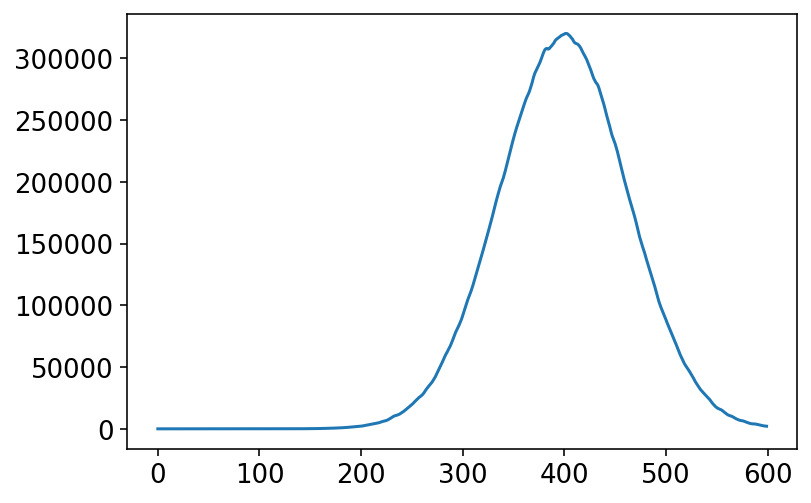

In [11]:
plt.plot(Ws_along_x_observe*factor_case_A)

In [19]:
def ccc(xo):
    return boundary_convolve('A', lambda_grid_filtered, Es_grid, Fx_grid, xvec, xo, zvec2, xvec2,  beta=beta, rho=rho, phi=0.1/rho)[0]

In [29]:
zvec.shape

(600,)

In [20]:
t1 = time.time()
haha = np.array(list(map(ccc, xvec)))
t2 = time.time()
print(t2-t1, 'sec')

22.18637776374817 sec


In [35]:
import concurrent.futures as cf

In [30]:
t1 = time.time()

with cf.ProcessPoolExecutor(max_workers=100) as executor:
    result = executor.map(ccc, xvec)
jaja = np.array(list(result))

t2 = time.time()
print('Mapping over xvec takes:', t2-t1,'sec')

Mapping over xvec takes: 16.47027850151062 sec


Text(0.5, 0.92, 'psi_s at the first step of chicane')

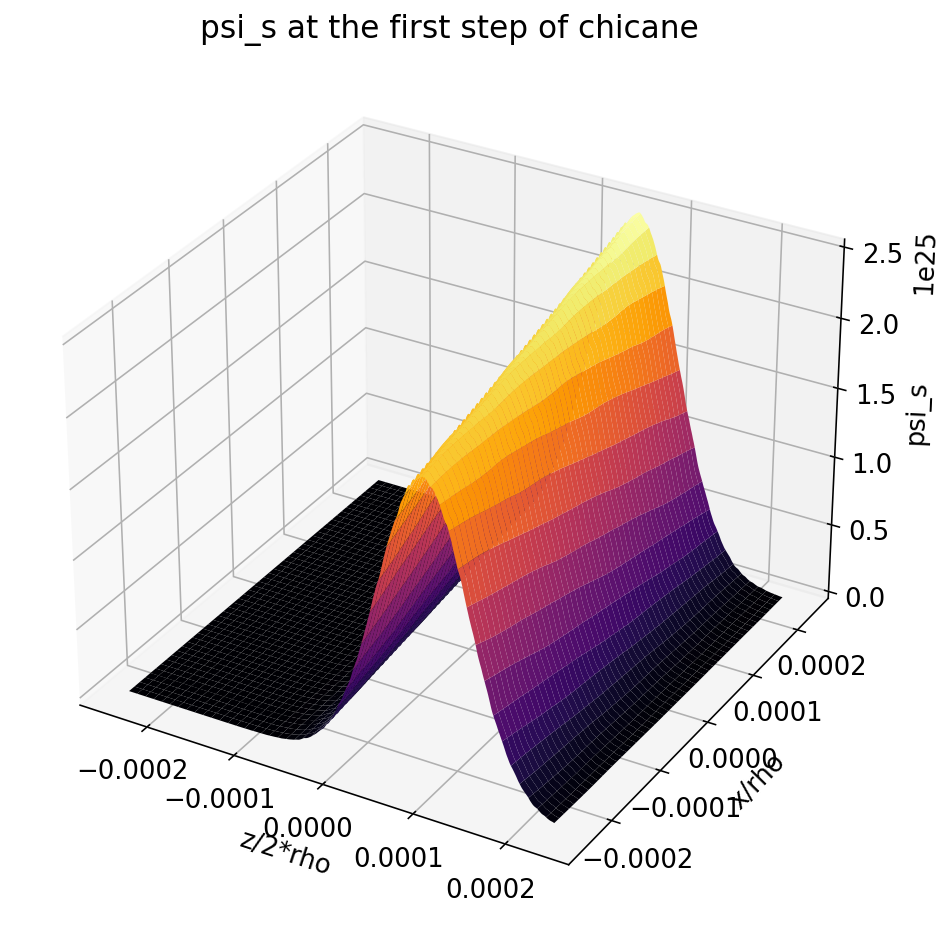

In [31]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing="ij")

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
#ax.contour3D(Z,X, psi_s_grid , 1000, cmap='inferno')
ax.plot_surface(Z,X, jaja.T, cmap='inferno')
ax.set_xlabel('z/2*rho')
ax.set_ylabel('x/rho')
ax.set_zlabel('psi_s')
ax.set_title('psi_s at the first step of chicane')

# Results

In [13]:
# Checking with Yunhai's example

xo_vec = [-2.5*sigma_x, 0.0, 2.5*sigma_x]

ffA = lambda xo : csr2d_kick_calc_case_A(beam[4], beam[0], charges,
    gamma=gamma, rho=rho, phi = 0.1/abs(rho), x_observe = xo,
    nz=100, nx=90, debug=True)
wake_listA = np.array(list(map(ffA, xo_vec)))

zvec = wake_listA[0][0]
xvec = wake_listA[0][1]

Depositing particles takes: 0.013427734375 s
Computing potential grids take: 0.005983114242553711 s
Convolution takes: 0.0056476593017578125 s
Depositing particles takes: 0.013232946395874023 s
Computing potential grids take: 0.005832672119140625 s
Convolution takes: 0.005411624908447266 s
Depositing particles takes: 0.013232707977294922 s
Computing potential grids take: 0.005833148956298828 s
Convolution takes: 0.005491495132446289 s


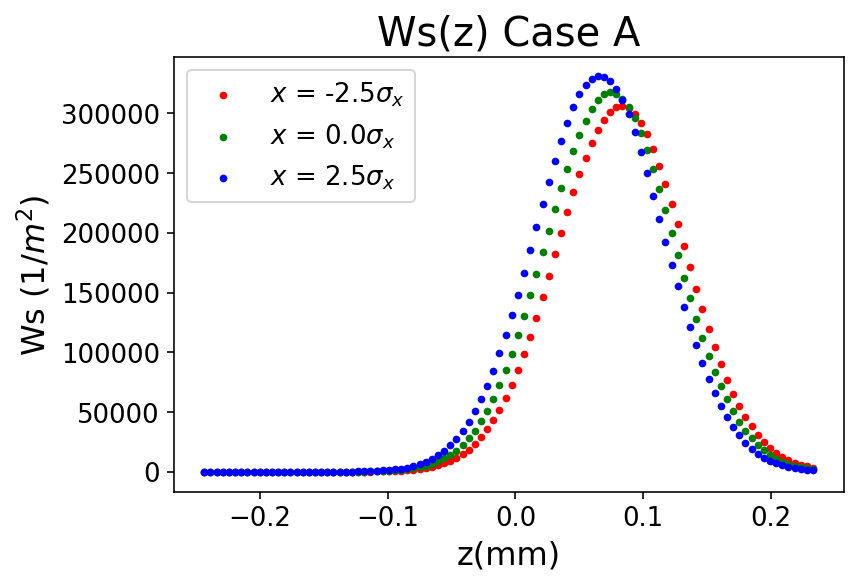

In [14]:
plt.scatter(zvec*10**3,wake_listA[0][2], color='red', label='$x$ = '+str(xo_vec[0]/sigma_x) + '$\sigma_x$', s=8 )
plt.scatter(zvec*10**3,wake_listA[1][2], color='green', label='$x$ = '+str(xo_vec[1]/sigma_x) + '$\sigma_x$', s=8 )
plt.scatter(zvec*10**3,wake_listA[2][2], color='blue', label='$x$ = '+str(xo_vec[2]/sigma_x) + '$\sigma_x$', s=8 )

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('Ws $(1/m^2)$', fontsize=16)
plt.title('Ws(z) Case A',  fontsize=20)
plt.legend()

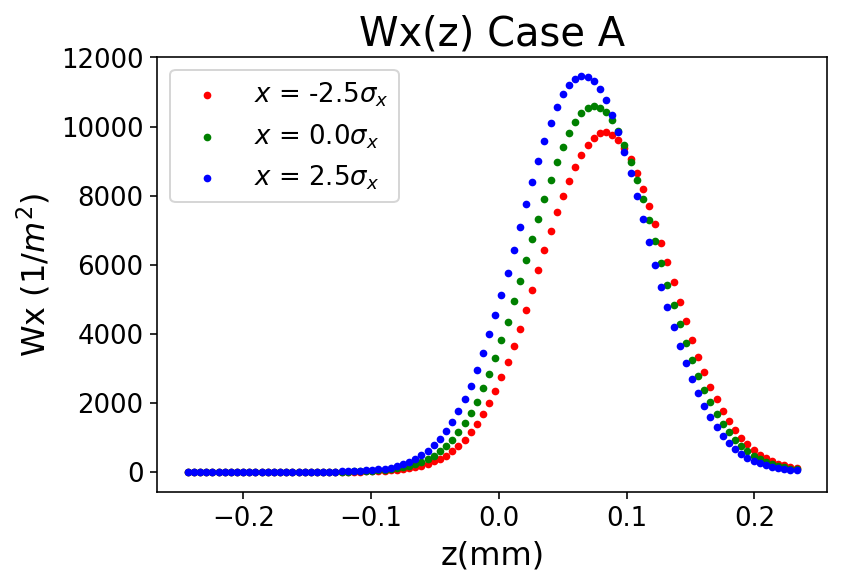

In [15]:
plt.scatter(zvec*10**3,wake_listA[0][3], color='red', label='$x$ = '+str(xo_vec[0]/sigma_x) + '$\sigma_x$', s=8 )
plt.scatter(zvec*10**3,wake_listA[1][3], color='green', label='$x$ = '+str(xo_vec[1]/sigma_x) + '$\sigma_x$', s=8 )
plt.scatter(zvec*10**3,wake_listA[2][3], color='blue', label='$x$ = '+str(xo_vec[2]/sigma_x) + '$\sigma_x$', s=8 )

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('Wx $(1/m^2)$', fontsize=16)
plt.title('Wx(z) Case A',  fontsize=20)
plt.legend()

In [30]:
x_observe = 0.0

phi_vec = [0.0045, 0.005, 0.006, 0.01, 0.02, 0.03]
phi_vec = [0.008, 0.02, 0.04, 0.06, 0.08, 0.1]

phi_vec = [0.02, 0.03, 0.04, 0.06, 0.08, 0.1]
#phi_vec = [0.0666667]

ffA = lambda a : csr2d_kick_calc_case_A(beam[4], beam[0], charges,
    gamma=gamma, rho=rho, phi = a, x_observe = 0,
    nz=600, nx=500, debug=True)
wake_listA = np.array(list(map(ffA, phi_vec)))
zvec = wake_listA[0][0]

Depositing particles takes: 0.020313739776611328 s
Computing potential grids take: 0.2005167007446289 s
Convolution takes: 0.27933764457702637 s
Depositing particles takes: 0.016771554946899414 s
Computing potential grids take: 0.2256307601928711 s
Convolution takes: 0.29228878021240234 s
Depositing particles takes: 0.02974390983581543 s
Computing potential grids take: 0.23762130737304688 s
Convolution takes: 0.2748229503631592 s
Depositing particles takes: 0.015590429306030273 s
Computing potential grids take: 0.19539856910705566 s
Convolution takes: 0.3158552646636963 s
Depositing particles takes: 0.017101049423217773 s
Computing potential grids take: 0.21492576599121094 s
Convolution takes: 0.30759572982788086 s
Depositing particles takes: 0.019048690795898438 s
Computing potential grids take: 0.20804333686828613 s
Convolution takes: 0.27488136291503906 s


In [31]:
def lamb_1d(z):
    return 1/(sigma_z*np.sqrt(2*np.pi))* np.exp(-z**2 / 2 / sigma_z**2)
def plot_Ws_caseA_theory(phi, color, label=None):
    plt.plot(zvec*1e3, 4/phi/rho * lamb_1d( zvec - rho*phi**3/6), color = color, linewidth=4, label = label)
    
def plot_Wx_caseA_theory(phi, color, label=None):
    plt.plot(zvec*1e3, 2/rho * lamb_1d( zvec - rho*phi**3/6), color = color, linewidth=4, label = label)

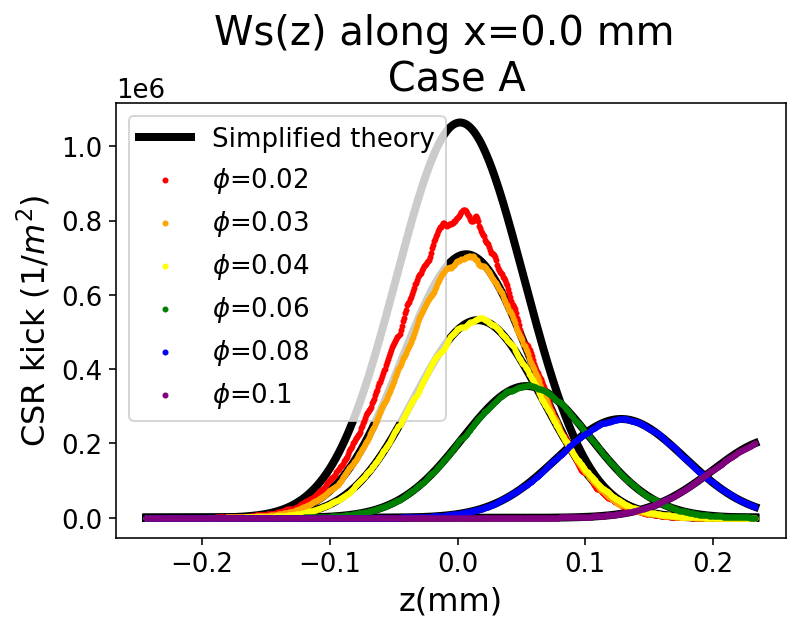

In [32]:
plt.scatter(zvec*10**3,wake_listA[0][2], color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4)
plt.scatter(zvec*10**3,wake_listA[1][2], color='orange', label='$\phi$='+str(phi_vec[1]),zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_listA[2][2], color='yellow', label='$\phi$='+str(phi_vec[2]),zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_listA[3][2], color='green', label='$\phi$='+str(phi_vec[3]),zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_listA[4][2], color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_listA[5][2], color='purple', label='$\phi$='+str(phi_vec[5]),zorder=10, s=4  )


plot_Ws_caseA_theory(phi_vec[0], 'black', 'Simplified theory')
plot_Ws_caseA_theory(phi_vec[1], 'black')
plot_Ws_caseA_theory(phi_vec[2], 'black')
plot_Ws_caseA_theory(phi_vec[3], 'black')
plot_Ws_caseA_theory(phi_vec[4], 'black')
plot_Ws_caseA_theory(phi_vec[5], 'black')

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('CSR kick $(1/m^2)$', fontsize=16)
plt.title('Ws(z) along x='+str(x_observe*1000)+' mm \n Case A',  fontsize=20)
plt.legend()

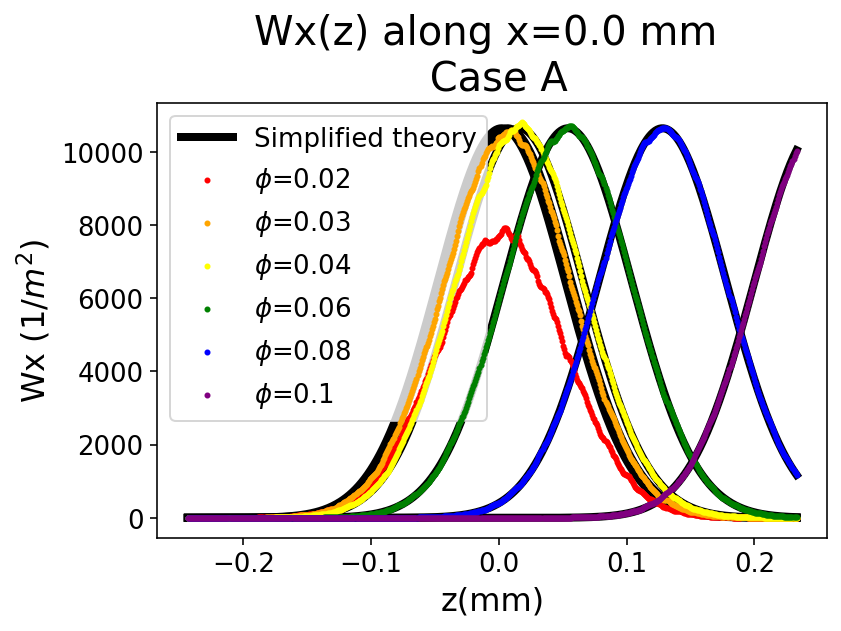

In [33]:
plt.scatter(zvec*10**3,wake_listA[0][3], color='red', label='$\phi$='+str(phi_vec[0]), zorder=10, s=4)
plt.scatter(zvec*10**3,wake_listA[1][3], color='orange', label='$\phi$='+str(phi_vec[1]),zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_listA[2][3], color='yellow', label='$\phi$='+str(phi_vec[2]),zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_listA[3][3], color='green', label='$\phi$='+str(phi_vec[3]),zorder=10, s=4   )
plt.scatter(zvec*10**3,wake_listA[4][3], color='blue', label='$\phi$='+str(phi_vec[4]), zorder=10, s=4  )
plt.scatter(zvec*10**3,wake_listA[5][3], color='purple', label='$\phi$='+str(phi_vec[5]),zorder=10, s=4  )


plot_Wx_caseA_theory(phi_vec[0], 'black', 'Simplified theory')
plot_Wx_caseA_theory(phi_vec[1], 'black')
plot_Wx_caseA_theory(phi_vec[2], 'black')
plot_Wx_caseA_theory(phi_vec[3], 'black')
plot_Wx_caseA_theory(phi_vec[4], 'black')
plot_Wx_caseA_theory(phi_vec[5], 'black')

plt.xlabel('z(mm)', fontsize=16)
plt.ylabel('Wx $(1/m^2)$', fontsize=16)
plt.title('Wx(z) along x='+str(x_observe*1000)+' mm \n Case A',  fontsize=20)
plt.legend()

# Testing to map over x_observe efficiently

### gnu vectorize testing (failing)

In [62]:
import numpy as np

from numba import guvectorize

@guvectorize(['void(float64[:], intp[:], float64[:])'],
             '(n),()->(n)')
def move_mean(a, window_arr, out):
    window_width = window_arr[0]
    asum = 0.0
    count = 0
    for i in range(window_width):
        asum += a[i]
        count += 1
        out[i] = asum / count
    for i in range(window_width, len(a)):
        asum += a[i] - a[i - window_width]
        out[i] = asum / count

In [67]:
@guvectorize([(int64[:],int64[:])], '(n)->()')
def f(x, out):
    out[:]=x.sum()

In [84]:
from numba import vectorize, float64, guvectorize, int64

from csr2d.core2 import Es_case_A, Fx_case_A

#@vectorize([float64(float64, float64, float64, float64, float64, float64, float64)])

@guvectorize([(int64, int64, float64, float64, float64, float64, float64, float64[:,:])], '(),(),(),(),(),(),()->()')
def green_meshes_case_A_test(nz, nx, dz, dx, rho, beta, alp, Es_case_A_grid):
    
    rho_sign = 1 if rho>=0 else -1
    
    # Change to internal coordinates
    dx = dx/rho
    dz = dz/(2*abs(rho))
    
    # Double-sized array for convolution with the density
    zvec2 = np.arange(-nz+1,nz+1,1)*dz # center = 0 is at [nz-1]
    xvec2 = np.arange(-nx+1,nx+1,1)*dx # center = 0 is at [nx-1]
    
    
    zm2, xm2 = np.meshgrid(zvec2, xvec2, indexing="ij")
    
    Es_case_A_grid = Es_case_A(zm2, xm2, beta, alp) # Numba routines!
    Fx_case_A_grid = Fx_case_A(zm2, xm2, beta, alp) # Numba routines!
    
    #return Es_case_A_grid
    #return Es_case_A_grid, Fx_case_A_grid, zvec2*2*rho, xvec2*rho

TypeError: type and shape signature mismatch for arg #8

In [83]:
green_meshes_case_A_test(100, 100, 0.001, 0.001, 1.5, 0.999999, 0.04)

4.63557882641196e-310

### Write a new  convolve_2d to compute the values ONLY along x = x_observe

In [55]:
def csr2d_kick_calc_case_A_test2(
    z_b, x_b, weight, *,
    gamma=None, rho=None, phi = None, x_observe = None,
    nz=100, nx=100,
    xlim=None, zlim=None, reuse_psi_grids=False, psi_s_grid_old=None, psi_x_grid_old=None,
    map_f=map, species="electron", imethod='map_coordinates', debug=False):
    
    zvec, xvec, dz, dx, lambda_grid_filtered, lambda_grid_filtered_prime = \
    compute_dist_grid(z_b, x_b, weight, nz=nz, nx=nx, xlim=xlim, zlim=zlim, debug=debug)
    
    beta = np.sqrt(1 - 1 / gamma ** 2)

    if debug:
        t3 = time.time()

    if reuse_psi_grids == True:
        psi_s_grid = psi_s_grid_old
        psi_x_grid = psi_x_grid_old

    else:
        # Creating the potential grids        
        Es_grid, Fx_grid, zvec2, xvec2 = green_meshes_case_A(nz, nx, dz, dx, rho=rho, beta=beta, alp=phi/2) 
    
    if debug:
        t4 = time.time()
        print("Computing potential grids take:", t4 - t3, "s")

    
    # Boundary condition 
    temp = (x_observe - xvec2)/rho
    zi_vec = rho*(phi-beta*np.sqrt(temp**2 + 4*(1+temp)*np.sin(phi/2)**2))
    #zo_vec = -beta*np.abs(x_observe - xvec2)  

    # Want "True" if (z < zi), where the potential grid values are set to ZERO
    condition_grid = np.array([(zvec2 < zi_vec[i]) for i in range(len(xvec2))])
    Es_grid_bounded = np.where(condition_grid.T, 0, Es_grid)
    Fx_grid_bounded = np.where(condition_grid.T, 0, Fx_grid)

    if debug:
        t5 = time.time()
    
    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    #print( x_observe_index )
    
    ######## FFT method with extra computation ( still fast... ) ###########

    conv_s, conv_x = fftconvolve2(lambda_grid_filtered, Es_grid_bounded, Fx_grid_bounded)

    ####ccc = lambda ix1 : my_2d_convolve(lambda_grid_filtered, Es_grid_bounded, ix1, x_observe_index) 
       
    Ws_grid = (1/gamma**2 / rho**2) * (conv_s) * (dz*dx)
    Ws_along_x_observe = Ws_grid[:,x_observe_index]
    
    ######     # Replacing the fftconvolve with a new convolution function #####
    ######### William writing new Convolve to compute values only along specified x_oberseve_index
    #Ws_along_x_observe = my_super_convolve2(lambda_grid_filtered, Es_grid_bounded, np.arange(len(zvec)), x_observe_index)* (1/gamma**2 / rho**2) * (dz*dx)
    ###############################################
    

    if debug:
        t6 = time.time()
        print("Convolution takes:", t6 - t5, "s")
    
    #return Ws_along_x_observe, lambda_grid_filtered, Es_grid_bounded
    return Ws_along_x_observe, lambda_grid_filtered, Es_grid

In [74]:
hhh, G1, G2= csr2d_kick_calc_case_A_test2(beam[4], beam[0], charges,
    gamma=gamma, rho=rho, phi = 0.1/rho, x_observe = 1e-3,
    nz=600, nx=500, debug=True)

Depositing particles takes: 0.0348505973815918 s
Computing potential grids take: 0.20863866806030273 s
Convolution takes: 0.3059353828430176 s


In [57]:
hhh, G1, G2= csr2d_kick_calc_case_A_test2(beam[4], beam[0], charges,
    gamma=gamma, rho=rho, phi = 0.1/rho, x_observe = 1e-3,
    nz=15, nx=12, debug=True)

Depositing particles takes: 0.01782703399658203 s
Computing potential grids take: 0.0004343986511230469 s
Convolution takes: 0.0007092952728271484 s


In [48]:
bb = np.array(([1,2],[4,5],[6,7]))

cc = np.array(([[1,2,3,2],[2,3,4,3],[3,4,8,9],[4,5,4,3],[3,4,10,9],[1,5,9,3]]))

In [49]:
scipy.signal.convolve2d(bb, cc, mode='same')

array([[ 51,  79],
       [ 76, 111],
       [ 95, 135]])

In [58]:
my_2d_convolve(bb,cc, np.array(), 0)

51

In [7]:
from numba import njit

@njit
def my_2d_convolve(g1, g2, ix1, ix2):
    d1, d2 = g1.shape
    g2_flip = np.flip(g2)
    g2_cut = g2_flip[d1-ix1:2*d1-ix1, d2-ix2:2*d2-ix2]
    return np.sum(np.multiply( g1, g2_cut) )

@njit
def my_super_convolve(g1, g2, ix1_vec, ix2):
    return np.array([my_2d_convolve(g1, g2, ix1, ix2) for ix1 in ix1_vec])

In [87]:
%%timeit
my_super_convolve(G1, G2, np.arange(600), 7)

1.16 s ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [92]:
from numba import njit
@njit
def my_2d_convolve2(g1, g2, ix1, ix2):
    d1, d2 = g1.shape
    g2_flip = np.flip(g2)
    g2_cut = g2_flip[d1-ix1:2*d1-ix1, d2-ix2:2*d2-ix2]
    
    sums = 0
    for i in range(d1):
        for j in range(d2):
            sums+= g1[i,j]*g2_cut[i,j]
    return sums

@njit
def my_super_convolve2(g1, g2, ix1_vec, ix2):
    return np.array([my_2d_convolve2(g1, g2, ix1, ix2) for ix1 in ix1_vec])

In [82]:
%%timeit
my_super_convolve2(G1, G2, np.arange(600), 7)

270 ms ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
# not faster than my_2d_convolve2...
@njit
def my_2d_convolve3(g1, g2, ix1, ix2):
    d1, d2 = g1.shape
    g2_flip = np.flip(g2)
    #g2_cut = g2_flip[d1-ix1:2*d1-ix1, d2-ix2:2*d2-ix2]
    
    sums = 0
    for i in range(d1):
        for j in range(d2):
            aa = d1-ix1+i
            bb = 2*d1-ix1+i
            cc = d2-ix2+j
            dd = 2*d2-ix2+j
            sums+= g1[i,j]*g2_flip[aa, cc]

    return sums

@njit
def my_super_convolve3(g1, g2, ix1_vec, ix2):
    return np.array([my_2d_convolve3(g1, g2, ix1, ix2) for ix1 in ix1_vec])

In [91]:
from numba import njit
@njit
def my_2d_convolve4(g1, g2, g3, ix1, ix2):
    d1, d2 = g1.shape
    
    g2_flip = np.flip(g2)
    g2_cut = g2_flip[d1-ix1:2*d1-ix1, d2-ix2:2*d2-ix2]

    g3_flip = np.flip(g3)
    g3_cut = g3_flip[d1-ix1:2*d1-ix1, d2-ix2:2*d2-ix2]
    
    sums2 = 0
    sums3 = 0
    for i in range(d1):
        for j in range(d2):
            sums2 += g1[i,j]*g2_cut[i,j]
            sums3 += g1[i,j]*g3_cut[i,j]
    return sums2, sums3

@njit
def my_super_convolve4(g1, g2, g3, ix1_vec, ix2):
    v1 = np.array([my_2d_convolve4(g1, g2, g3, ix1, ix2)[0] for ix1 in ix1_vec])
    v2 = np.array([my_2d_convolve4(g1, g2, g3, ix1, ix2)[1] for ix1 in ix1_vec])
    return v1, v2

In [85]:
%%timeit
my_super_convolve3(G1, G2, np.arange(600), 7)

377 ms ± 30.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [119]:
from numba import vectorize, float64, int64

#def my_2d_convolve3(g1, g2, ix1, ix2):

@vectorize([float64(int64)])
def my_2d_convolve2_vec(ix1):
    return my_2d_convolve2(G1, G2, ix1, 45)

In [120]:
c1 = my_super_convolve(G1,G2, np.arange(600), 45)
c2 = my_super_convolve2(G1,G2, np.arange(600), 45)

c2v = my_2d_convolve2_vec(np.arange(600))

In [88]:
ccc = lambda ix2 : my_super_convolve2(G1, G2, np.arange(600), ix2)

In [93]:
ccc = lambda ix2 : my_super_convolve2(G1, G2, np.arange(600), ix2)

t1 = time.time()
haha = np.array(list(map(ccc, np.arange(500))))
t2 = time.time()
print(t2-t1, 'sec')

128.46934700012207 sec


Text(0.5, 0.92, 'psi_s at the first step of chicane')

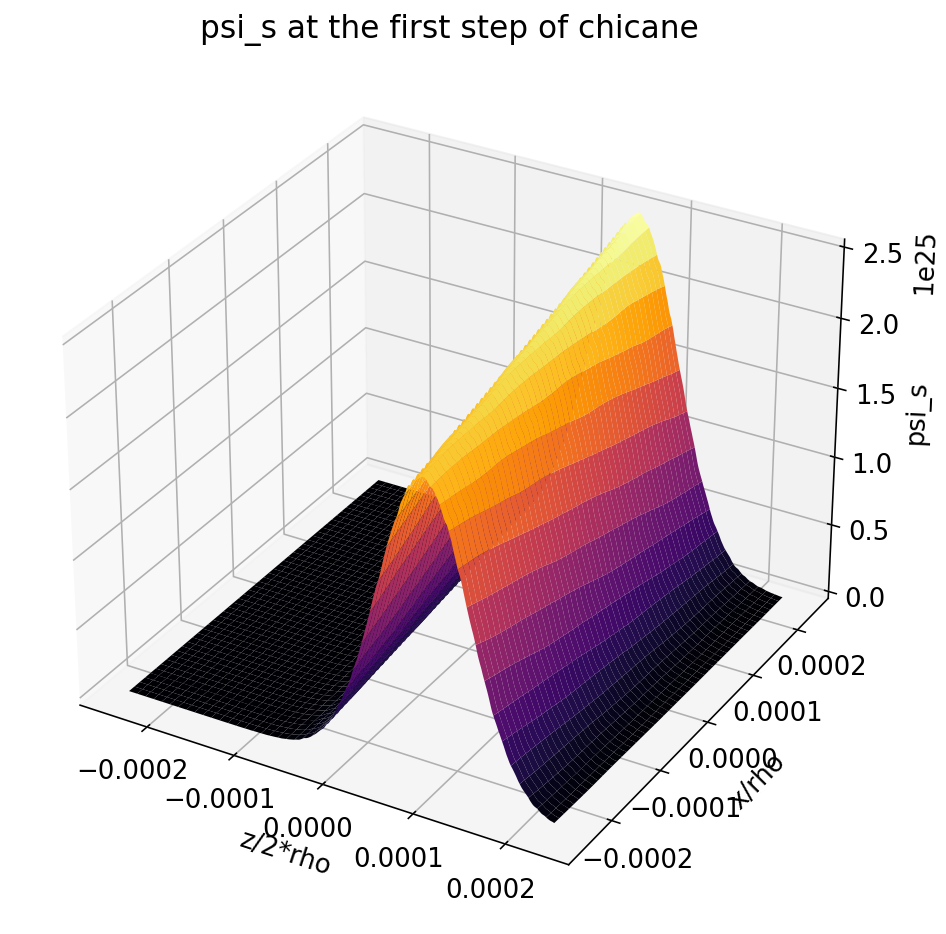

In [106]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing="ij")

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
#ax.contour3D(Z,X, psi_s_grid , 1000, cmap='inferno')
ax.plot_surface(Z,X, haha.T, cmap='inferno')
ax.set_xlabel('z/2*rho')
ax.set_ylabel('x/rho')
ax.set_zlabel('psi_s')
ax.set_title('psi_s at the first step of chicane')

In [103]:
jaja = haha.reshape((500,600)).T

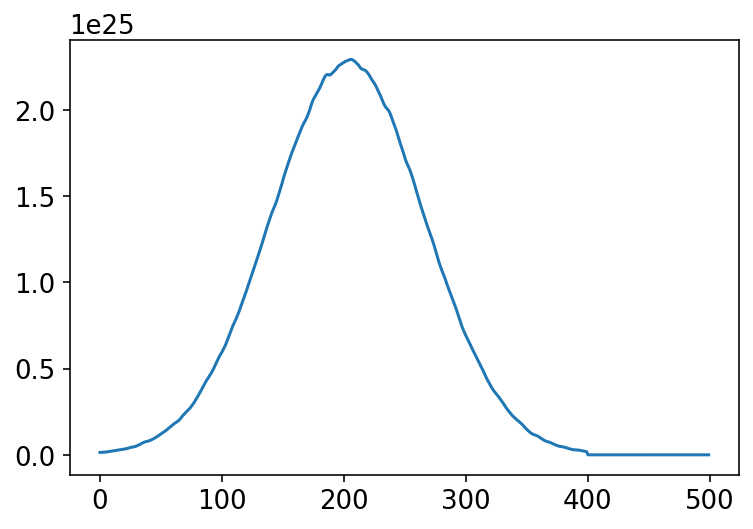

In [100]:
plt.plot(kaka[250,:])

In [45]:
ccc = lambda ix1 : my_2d_convolve(lambda_grid_filtered, Es_grid_bounded, ix1, x_observe_index)

In [66]:
csr2d_kick_calc_case_A_test2(beam[4], beam[0], charges,
    gamma=gamma, rho=rho, phi = 0.1/rho, x_observe = 1e-3,
    nz=500, nx=31, debug=True)[0][0:20]

Depositing particles takes: 0.016072750091552734 s
Computing potential grids take: 0.010486364364624023 s
Convolution takes: 0.8338332176208496 s


array([4.67531008e-05, 4.96433447e-05, 5.17759998e-05, 5.69218505e-05,
       6.49030737e-05, 7.50786576e-05, 8.65203234e-05, 9.91935976e-05,
       1.11920224e-04, 1.25121926e-04, 1.39737608e-04, 1.55759780e-04,
       1.73062779e-04, 1.88622221e-04, 2.04959432e-04, 2.29559350e-04,
       2.58360489e-04, 2.90098662e-04, 3.26574648e-04, 3.67598232e-04])

In [23]:
csr2d_kick_calc_case_A_test2(beam[4], beam[0], charges,
    gamma=gamma, rho=rho, phi = 0.1/rho, x_observe = 1e-3,
    nz=500, nx=31, debug=True)[0][0:20]

Depositing particles takes: 0.013837099075317383 s
Computing potential grids take: 0.010105609893798828 s
30
Convolution takes: 0.045494794845581055 s


array([4.67531008e-05, 4.96433447e-05, 5.17759998e-05, 5.69218505e-05,
       6.49030737e-05, 7.50786576e-05, 8.65203234e-05, 9.91935976e-05,
       1.11920224e-04, 1.25121926e-04, 1.39737608e-04, 1.55759780e-04,
       1.73062779e-04, 1.88622221e-04, 2.04959432e-04, 2.29559350e-04,
       2.58360489e-04, 2.90098662e-04, 3.26574648e-04, 3.67598232e-04])

In [24]:
csr2d_kick_calc_case_A(beam[4], beam[0], charges,
    gamma=gamma, rho=rho, phi = 0.1/rho, x_observe = 1e-3,
    nz=500, nx=31, debug=True)[2][0:20]

Depositing particles takes: 0.013786077499389648 s
Computing potential grids take: 0.012373208999633789 s
Convolution takes: 0.015941858291625977 s


array([4.67531030e-05, 4.96433642e-05, 5.17760333e-05, 5.69218497e-05,
       6.49030873e-05, 7.50786443e-05, 8.65203142e-05, 9.91935815e-05,
       1.11920230e-04, 1.25121924e-04, 1.39737605e-04, 1.55759746e-04,
       1.73062768e-04, 1.88622218e-04, 2.04959422e-04, 2.29559346e-04,
       2.58360491e-04, 2.90098647e-04, 3.26574636e-04, 3.67598214e-04])

In [32]:
xo_vec = np.array([-2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5])*sigma_x

ffA = lambda xo : csr2d_kick_calc_case_A(beam[4], beam[0], charges,
    gamma=gamma, rho=rho, phi = 0.1/rho, x_observe = xo,
    nz=600, nx=500, debug=False)[2]

t1 = time.time()
kaka = np.array(list(map(ffA, xo_vec)))
t2 = time.time()

print('Mapping over xvec takes:', t2-t1,'sec')

Mapping over xvec takes: 10.411369323730469 sec


In [ ]:
with cf.ProcessPoolExecutor(max_workers=20) as executor:

In [113]:
ffA2 = lambda xo : csr2d_kick_calc_case_A_test2(beam[4], beam[0], charges,
    gamma=gamma, rho=rho, phi = 0.1/rho, x_observe = xo, map_f=executor.map,
    nz=600, nx=500, debug=True)[0]

t1 = time.time()
with cf.ProcessPoolExecutor(max_workers=20) as executor:
    kaka2 = np.array(list(map(ffA2, xo_vec)))
t2 = time.time()

print('Mapping over xvec takes:', t2-t1,'sec')

Depositing particles takes: 0.03520035743713379 s
Computing potential grids take: 0.25742268562316895 s
Convolution takes: 0.35955023765563965 s
Depositing particles takes: 0.0318760871887207 s
Computing potential grids take: 0.2682654857635498 s
Convolution takes: 0.32720518112182617 s
Depositing particles takes: 0.022472858428955078 s
Computing potential grids take: 0.22673368453979492 s
Convolution takes: 0.40744519233703613 s
Depositing particles takes: 0.019806385040283203 s
Computing potential grids take: 0.25180840492248535 s
Convolution takes: 0.374314546585083 s
Depositing particles takes: 0.023778200149536133 s
Computing potential grids take: 0.2613818645477295 s
Convolution takes: 0.33347344398498535 s
Depositing particles takes: 0.021903514862060547 s
Computing potential grids take: 0.21322369575500488 s
Convolution takes: 0.30672502517700195 s
Depositing particles takes: 0.018158435821533203 s
Computing potential grids take: 0.2531285285949707 s
Convolution takes: 0.349878

In [67]:
ffA2 = lambda xo : csr2d_kick_calc_case_A_test2(beam[4], beam[0], charges,
    gamma=gamma, rho=rho, phi = 0.1/rho, x_observe = xo, map_f=executor.map,
    nz=600, nx=500, debug=False)[0]

t1 = time.time()
with cf.ProcessPoolExecutor(max_workers=20) as executor:
    kaka2 = np.array(list(map(ffA2, xo_vec)))
t2 = time.time()

print('Mapping over xvec takes:', t2-t1,'sec')

Mapping over xvec takes: 22.241637468338013 sec


In [71]:
%%time
r1 = ffA(0)

CPU times: user 838 ms, sys: 39 ms, total: 877 ms
Wall time: 870 ms


In [74]:
ffA2 = lambda xo : csr2d_kick_calc_case_A_test2(beam[4], beam[0], charges,
    gamma=gamma, rho=rho, phi = 0.1/rho, x_observe = xo, map_f=map,
    nz=600, nx=500, debug=False)[0]

In [75]:
%%time
r2 = ffA2(0)

CPU times: user 2.06 s, sys: 8.25 ms, total: 2.07 s
Wall time: 2.05 s


# Below are scratch

In [203]:
g1, g2 = csr2d_kick_calc_case_A_test2(beam[4], beam[0], charges,
    gamma=gamma, rho=rho, phi = 0.1/rho, x_observe = 0,
    nz=21, nx=11, debug=True)

conv_s = fftconvolve2(g1,g2)[0]

Depositing particles takes: 0.013004302978515625 s
Computing potential grids take: 0.00033020973205566406 s
Convolution takes: 0.001028299331665039 s
5


In [210]:
haha = scipy.signal.convolve2d(g1, g2, mode='same')

In [404]:
haha[:,5]

array([ 0.00000000e+00, -4.05442069e+16, -3.61081472e+17, -1.86870956e+21,
       -1.12021258e+21, -1.23395724e+20,  1.12066495e+21,  2.61190450e+21,
        4.35034610e+21,  6.33623519e+21,  1.02208222e+22,  1.37703661e+22,
        1.63146603e+22,  1.74453720e+22,  1.70082642e+22,  1.50635502e+22,
        1.18952386e+22,  8.07136381e+21,  6.07119100e+21,  4.12679447e+21,
        2.23735977e+21])

In [381]:
conv_s[:,5]

array([-6.77231095e+05, -4.05442069e+16, -3.61081472e+17, -1.86870956e+21,
       -1.12021258e+21, -1.23395724e+20,  1.12066495e+21,  2.61190450e+21,
        4.35034610e+21,  6.33623519e+21,  1.02208222e+22,  1.37703661e+22,
        1.63146603e+22,  1.74453720e+22,  1.70082642e+22,  1.50635502e+22,
        1.18952386e+22,  8.07136381e+21,  6.07119100e+21,  4.12679447e+21,
        2.23735977e+21])

In [376]:
g2_flip = np.flip(g2)
g2_cut = g2_flip[1:22,1:12]

#g2_cut = g2[10:31,6:17]

In [398]:
#from numba import njit
#@np.vectorize

def my_2d_convolve(g1, g2, ix1, ix2):
    d1, d2 = g1.shape
    g2_flip = np.flip(g2)
    g2_cut = g2_flip[d1-ix1:2*d1-ix1, d2-ix2:2*d2-ix2]
    return np.sum(np.multiply( g1, g2_cut))

ccc = lambda ix1 : my_2d_convolve(g1, g2, ix1, 5)
    
list(map(ccc,np.arange(11)))

In [26]:
#xvec = wake_listA[0][1]



In [421]:
kaka[0][0:10]

array([ 1.21555313e-11, -1.63753510e-11, -8.02788149e-12, -6.71493797e-12,
        3.43055084e-12, -1.44597409e-11,  1.14620475e-11, -1.17539277e-11,
        1.12299880e-11,  2.77183863e-13])

In [422]:
kaka2[0][0:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [337]:
bb = np.array(([1,2,3],[4,5,6],[7,8,9]))

cc = np.array(([[1,2,3,4,3,2],[2,3,4,5,4,3],[3,4,3,7,8,9],[4,5,4,3,2,1],[0,1,2,3,4,5],[5,5,7,8,6,1]]))


bb = np.array(([1,2],[4,5],[6,7]))

cc = np.array(([[1,2,3,2],[2,3,4,3],[3,4,8,9],[4,5,4,3],[3,4,10,9],[1,5,9,3]]))

scipy.signal.convolve2d(bb,cc, mode='same')

array([[ 51,  79],
       [ 76, 111],
       [ 95, 135]])

In [343]:
cc_flip = np.flip(cc)
cc_cut = cc_flip[3:6,2:4]
cc_flip 

array([[ 3,  9,  5,  1],
       [ 9, 10,  4,  3],
       [ 3,  4,  5,  4],
       [ 9,  8,  4,  3],
       [ 3,  4,  3,  2],
       [ 2,  3,  2,  1]])

In [344]:
cc_cut

array([[4, 3],
       [3, 2],
       [2, 1]])

In [345]:
np.sum(np.multiply( bb, cc_cut))

51

In [274]:
cc.shape

(6, 6)

In [248]:
cc = np.array(([[1,2,3,4,3,2],[2,3,4,5,4,3],[3,4,5,7,8,9],[4,5,4,3,2,1]]))
cc.shape

(4, 6)

In [249]:
np.sum(bb)

21

In [133]:
np.flip(bb)

array([[12, 11, 10],
       [ 9,  8,  7],
       [ 6,  5,  4],
       [ 3,  2,  1]])

In [103]:
np.multiply(bb,bb)

array([[ 1,  4,  9],
       [16, 25, 36],
       [49, 64, 81]])

In [92]:
kaka = np.array(list(map(ffA, xo_vec)))

In [96]:
kaka[0].shape

(4,)

In [17]:
conv_vec = lambda xx: conv_with_boundary(x_observe=xx, phi=0.01, rho=rho, zvec2=zvec2, xvec2=xvec2, xvec=xvec, lambda_or_lambdap_grid=lambda_grid_filtered, potential_or_field_grid= Es_grid_bounded)


In [ ]:
gaga = np.array(list(map(conv_vec, xvec)))
gaga.shape

In [ ]:
# This somehow doesn't work? ( or just take too long... )

#with cf.ProcessPoolExecutor(max_workers=20) as executor:
#    jaja = np.array(list(executor.map(conv_vec, xvec)))

Text(0.5, 0.92, 'psi_s at the first step of chicane')

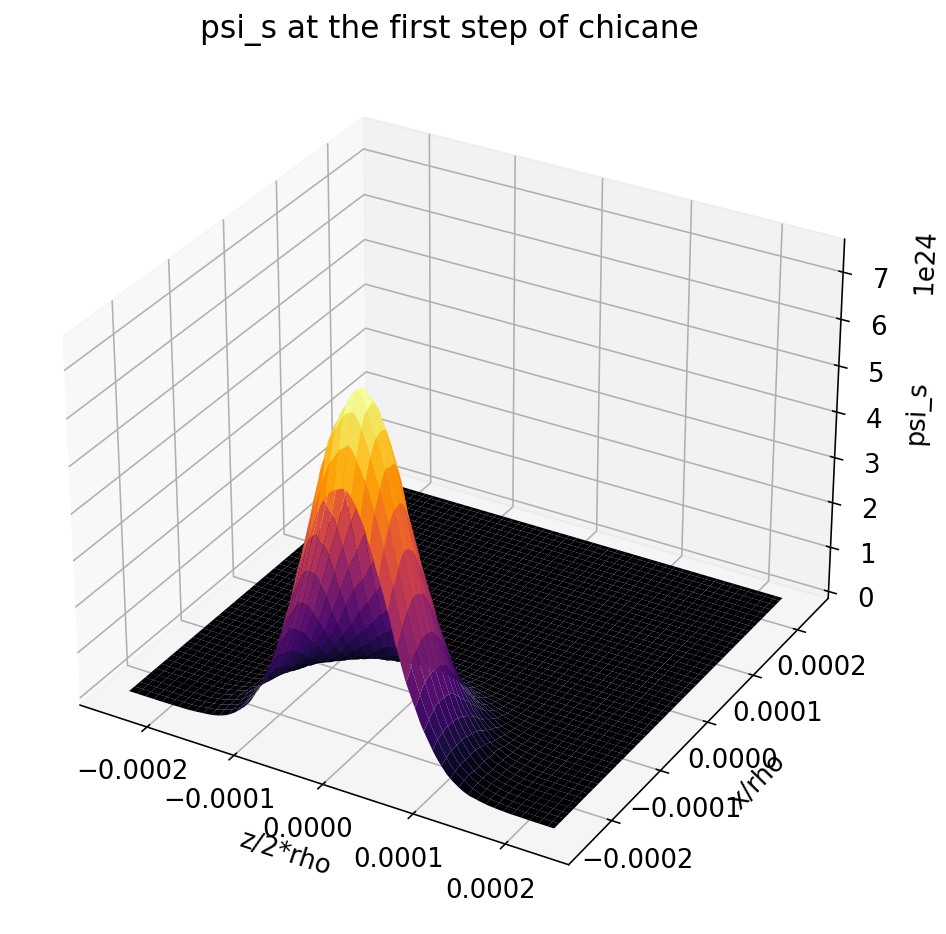

In [22]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec, xvec, indexing="ij")

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
#ax.contour3D(Z,X, psi_s_grid , 1000, cmap='inferno')
ax.plot_surface(Z,X, gaga.T, cmap='inferno')
ax.set_xlabel('z/2*rho')
ax.set_ylabel('x/rho')
ax.set_zlabel('psi_s')
ax.set_title('psi_s at the first step of chicane')

In [48]:
kaka = np.loadtxt("phi_0.01_wake.dat")

In [13]:
haha = conv_with_boundary(x_observe=0, phi=0.01, rho=rho, zvec2=zvec2, xvec2=xvec2, xvec=xvec, lambda_or_lambdap_grid=lambda_grid_filtered, potential_or_field_grid= Es_grid_bounded)

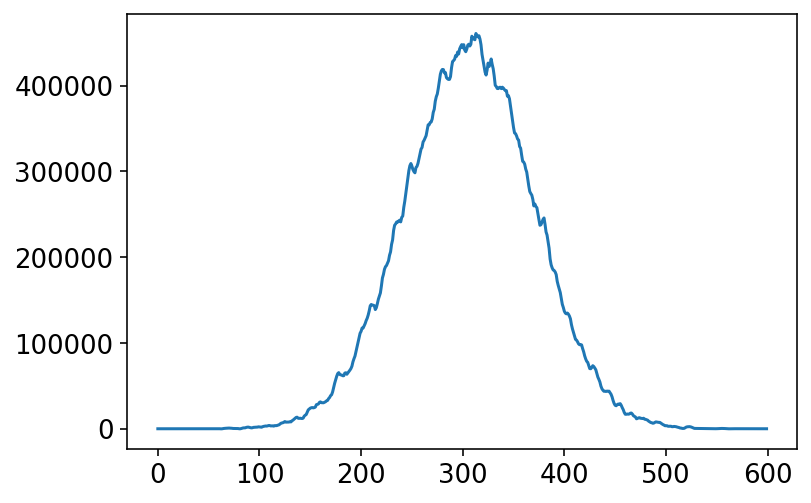

In [14]:
plt.plot(haha*(1/gamma**2 / rho**2) * (dz*dx))

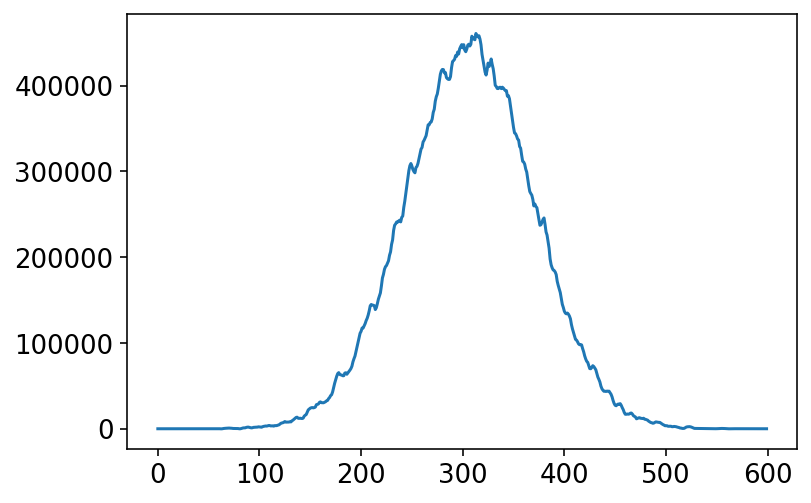

In [49]:
plt.plot(kaka)